In [1]:
import torchvision
from torchvision import transforms

rootpath = '/home/storopoli/Downloads'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

full_train_dataset = torchvision.datasets.FashionMNIST(root=rootpath, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root=rootpath, train=False, transform=trans)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.22MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]


In [2]:
from torch.utils.data import random_split

n = len(full_train_dataset)
n_train = int(n * 0.83)
n_valid = n - n_train

train_dataset, valid_dataset = random_split(full_train_dataset, [n_train, n_valid])

In [11]:
len(valid_dataset)

10200

In [18]:
from torch.utils.data import DataLoader

batch_size=32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import torch.nn as nn

In [24]:
class ConvNet(nn.Module):
  def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32), # adicionei isso
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64), # adicionei isso
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1000),
            nn.BatchNorm1d(1_000), # adicionei também
            nn.ReLU(),
            #nn.Dropout(0.2) # aqui também
        )
        self.fc2 = nn.Linear(1000, 10)

  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

# Instancia o Model()
model = ConvNet()

print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


In [25]:
from torch.optim import SGD
from torch.optim.lr_scheduler import OneCycleLR

loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
epochs = 10

optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=epochs,
    steps_per_epoch=len(train_loader)
)

In [ ]:
import torch

cuda_avaliabel = torch.cuda.is_available()
print(cuda_avaliabel)

True


In [16]:
device = torch.device('cuda:0' if cuda_avaliabel else 'cpu')

In [26]:
train_loss_list = []
train_acc_list = []
valid_acc_list = []
valid_loss_list = []

model.to(device)

for epoch in range(epochs):
  model.train()

  run_loss = 0.0
  total = 0
  correct = 0

  for i, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = loss_fn(outputs, labels)
        run_loss += loss.item() * labels.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Acuracia no treino
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    # Médias do treinamento
  train_acc_list.append(100 * correct / total)
  train_loss_list.append(run_loss / len(train_loader.dataset))

  # Validação
  model.eval()
  val_running_loss = 0.0
  val_total = 0
  val_correct = 0
  with torch.no_grad():
    for images, labels in valid_loader:
      images, labels = images.to(device), labels.to(device)

      output = model(images)
      loss = loss_fn(output, labels)

      # loss
      run_loss += loss.item() * images.shape[0]

      # acurácia
      _, predicted = torch.max(output, 1)
      correct += (predicted == labels).sum().item()
      total += labels.shape[0]

    valid_loss = run_loss / len(valid_loader.dataset)
    valid_acc = 100 * correct / total

    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    print(f"Época {epoch + 1}: acc: {valid_acc:.2f}, loss: {valid_loss:.4f}")


Época 1: acc: 85.66, loss: 2.3785
Época 2: acc: 88.92, loss: 1.7907
Época 3: acc: 91.26, loss: 1.3978
Época 4: acc: 92.88, loss: 1.1537
Época 5: acc: 94.15, loss: 0.9457
Época 6: acc: 95.56, loss: 0.7304
Época 7: acc: 96.56, loss: 0.5906
Época 8: acc: 97.70, loss: 0.4273
Época 9: acc: 98.45, loss: 0.3201
Época 10: acc: 98.75, loss: 0.2822


Text(0.5, 1.0, 'Acurácia (acc)')

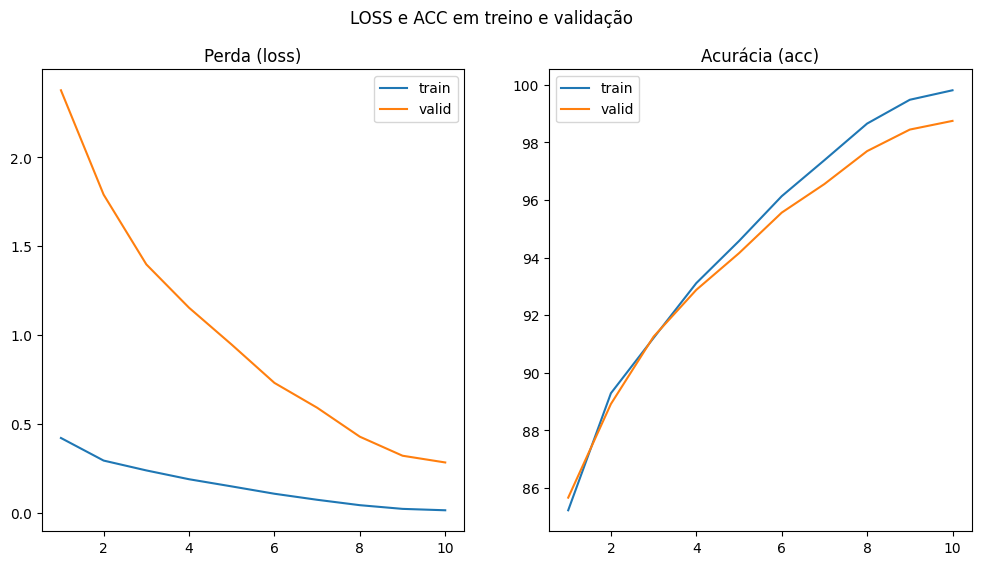

In [27]:
#EX: 3
# Plot loss e acurácia treino vc validação
from matplotlib import pyplot as plt

e = list(range(1, epochs + 1))

plt.figure('LOSS e ACC em treino e validação', figsize=(12,6))
plt.suptitle('LOSS e ACC em treino e validação')

# LOSS
axis1 = plt.subplot(1,2,1)
plt.plot(e, train_loss_list)
plt.plot(e, valid_loss_list)
plt.legend(['train', 'valid'])
axis1.set_title('Perda (loss)')

# ACC
axis2 =plt.subplot(1,2,2)
plt.plot(e, train_acc_list)
plt.plot(e, valid_acc_list)
plt.legend(['train', 'valid'])
axis2.set_title('Acurácia (acc)')

In [28]:
model.eval() # coloca o modelo em modo de avaliação (sem calcular gradientes)

model.to(device)

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Feed-forward com as imagens de teste
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # gera predições usando a função max()
        _, predicted = torch.max(outputs.data, 1)

        # Acumula total e corretas
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Acurácia do Modelo em 10k imagens de teste: {round((correct / total) * 100, 3)}")

Acurácia do Modelo em 10k imagens de teste: 92.87
